## Generating wind scenarios using PGscen ##

In this notebook we will use PGscen to create output scenarios for the wind generators in the Texas 7k power grid. This can also be done using the command line tool ```pgscen-wind``` installed as part of PGscen.

We start by setting up our scenario parameters and preparing the input datasets. In wind scenarios, we use all of the days other than the scenario day for training.

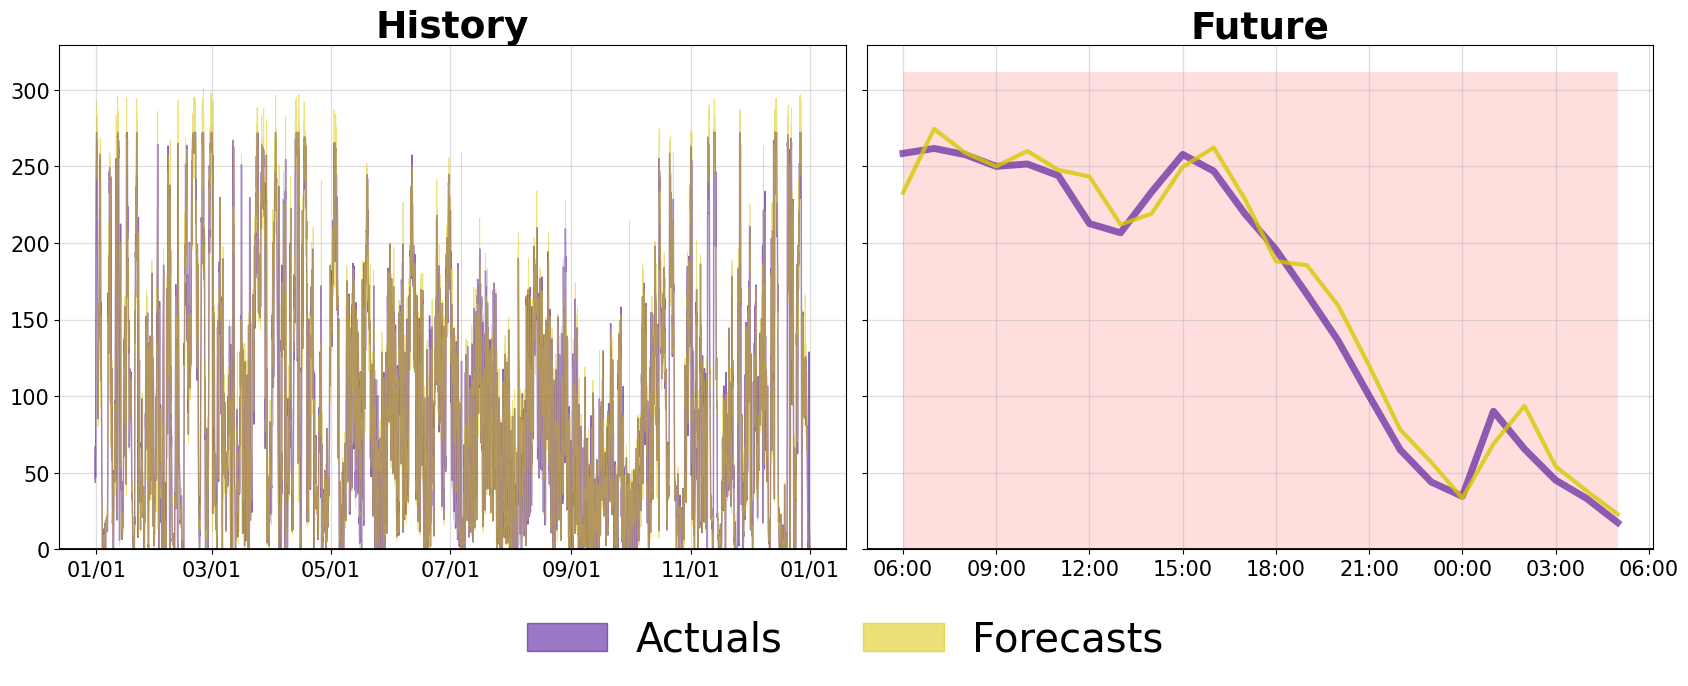

In [1]:
from pathlib import Path
import pandas as pd
from pgscen.command_line import (
    load_wind_data, split_actuals_hist_future, split_forecasts_hist_future)

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.dates as mdates
%matplotlib inline
plt.rcParams['figure.figsize'] = [19, 11]
from IPython.display import display


start_date = '2018-04-03'
cur_path = Path("day-ahead_wind.ipynb").parent.resolve()
data_dir = Path(cur_path, '..', "data", "ERCOT").resolve()

scenario_count = 1000
scen_start_time = pd.to_datetime(' '.join([start_date, "06:00:00"]), utc=True)
scen_timesteps = pd.date_range(start=scen_start_time, periods=24, freq='H')

wind_site_actual_df, wind_site_forecast_df, wind_meta_df = load_wind_data()

(wind_site_actual_hists,
     wind_site_actual_futures) = split_actuals_hist_future(
            wind_site_actual_df, scen_timesteps, in_sample=True)

(wind_site_forecast_hists,
     wind_site_forecast_futures) = split_forecasts_hist_future(
            wind_site_forecast_df, scen_timesteps, in_sample=True)

fig, (hist_ax, future_ax) = plt.subplots(figsize=(17, 6),
                                         nrows=1, ncols=2, sharey=True)

title_args = dict(weight='semibold', size=27)
actual_clr, fcst_clr = "#430093", "#D9C800"
plt_asset = wind_site_actual_df.columns[71]

hist_ax.set_title("History", **title_args)
hist_ax.plot(wind_site_actual_hists[plt_asset][8748:],
             c=actual_clr, lw=1, alpha=0.6)
hist_ax.plot(wind_site_forecast_hists['Forecast_time'],
             wind_site_forecast_hists[plt_asset],
             c=fcst_clr, lw=0.6, alpha=0.5)

future_ax.set_title("Future", **title_args)
future_ax.plot(wind_site_actual_futures[plt_asset],
               c=actual_clr, lw=5, alpha=0.6)
future_ax.plot(wind_site_forecast_futures['Forecast_time'],
               wind_site_forecast_futures[plt_asset],
               c=fcst_clr, lw=3, alpha=0.8)
future_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

future_ax.fill_between(wind_site_actual_futures.index[:24],
                       wind_site_actual_futures[plt_asset][:24].min() - 50,
                       wind_site_actual_futures[plt_asset][:24].max() + 50,
                       facecolor='red', edgecolor='none', alpha=0.13)

hist_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
future_ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

for ax in [hist_ax, future_ax]:
    ax.tick_params(which='both', labelsize=15)
    ax.grid(linewidth=0.9, alpha=0.41)
    ax.axhline(0, lw=1.3, c='black', alpha=1)
    ax.set_ylim((0, ax.get_ylim()[1]))

lgnd_ptchs = [Patch(color=actual_clr, alpha=0.53, label="Actuals"),
              Patch(color=fcst_clr, alpha=0.53, label="Forecasts")]

_ = fig.legend(handles=lgnd_ptchs, frameon=False, fontsize=29, ncol=2, loc=8,
               bbox_to_anchor=(0.5, -0.17), handletextpad=0.7)
fig.tight_layout(w_pad=1)

A crucial difference between the wind generator output model and the load demand model is that the former requires a unique regularization penalty for each pair of wind assets corresponding the physical distance between them, as generator sites that are closer together can be expected to have more similar weather patterns.

We thus use a metadata input dataset in our engine and calculate a normalized set of distances to use for our model. Note that fitting the model may take a few minutes.

,Blue Summit Wind III,Blue Summit repower,Bobcat Bluff,Bobcat Bluff repower,Brazos Wind Ranch,Briscoe,Broadview Energy JN LLC
Blue Summit Wind III,0.00,0.00,0.88,0.72,2.27,2.09,3.82
Blue Summit repower,0.00,0.00,0.88,0.72,2.27,2.09,3.82
Bobcat Bluff,0.88,0.88,0.00,0.16,2.69,2.87,4.60
Bobcat Bluff repower,0.72,0.72,0.16,0.00,2.61,2.73,4.47
Brazos Wind Ranch,2.27,2.27,2.69,2.61,0.00,1.47,2.57
Briscoe,2.09,2.09,2.87,2.73,1.47,0.00,1.74
Broadview Energy JN LLC,3.82,3.82,4.60,4.47,2.57,1.74,0.00


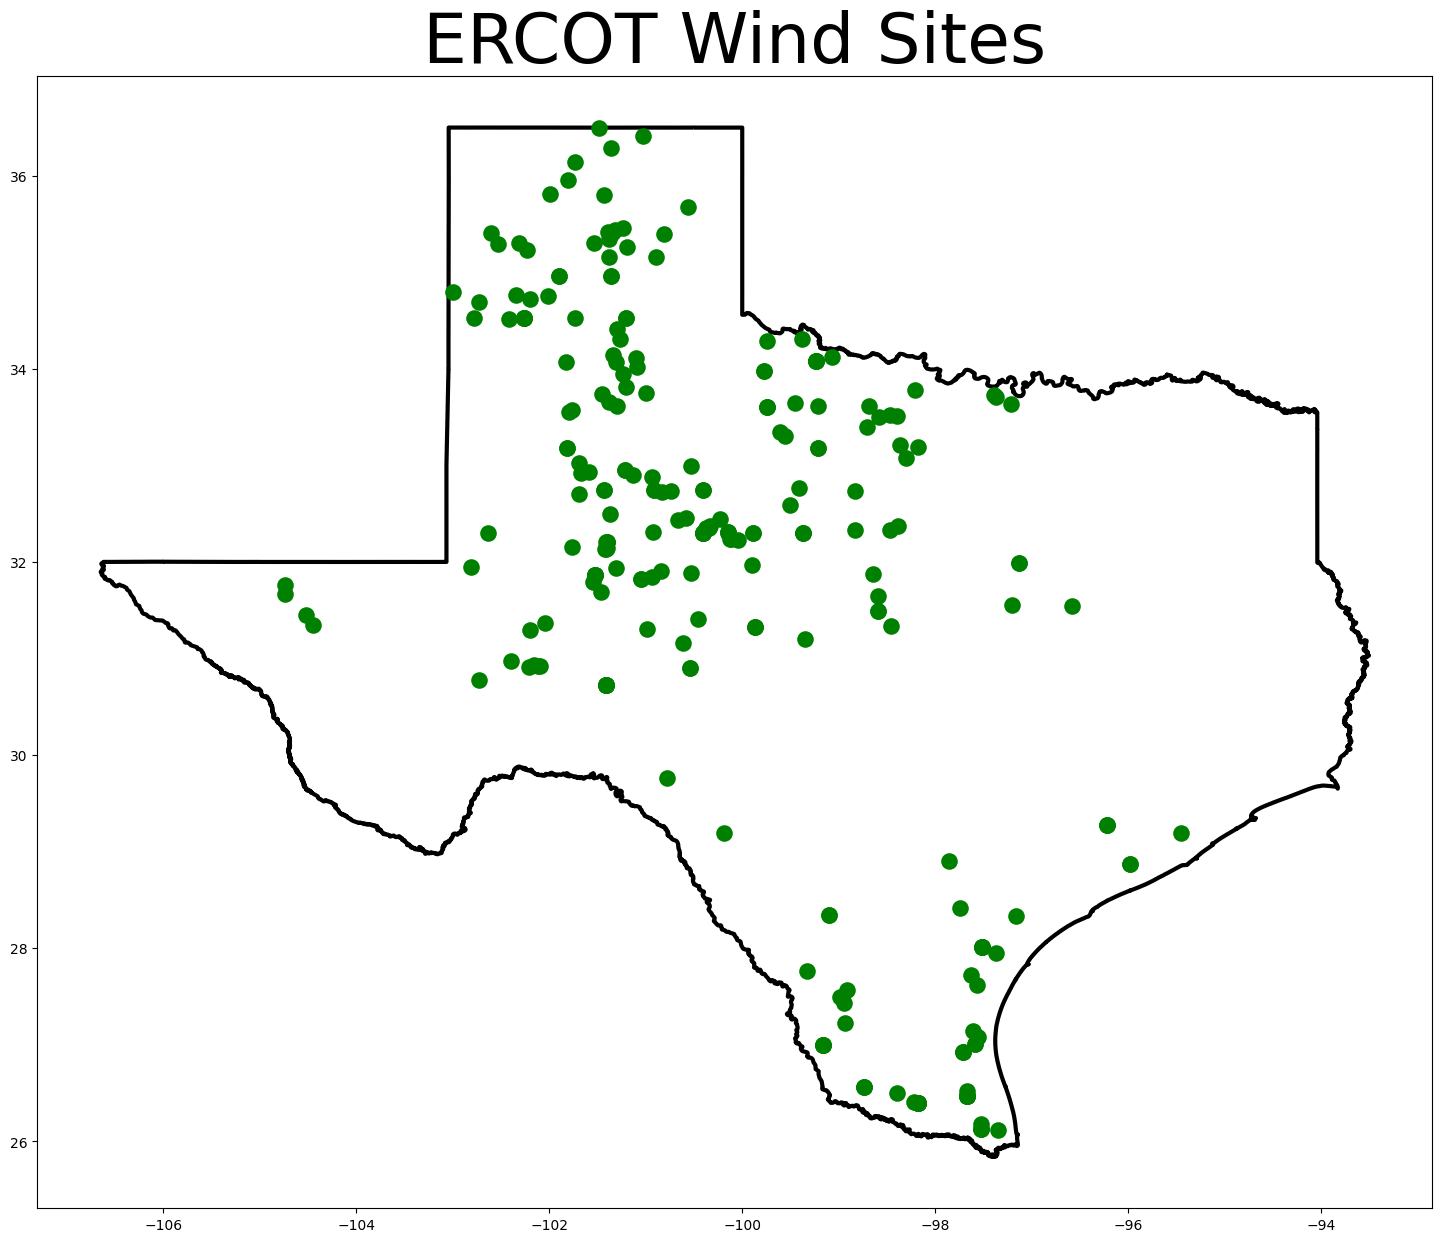

In [2]:
from pgscen.engine import GeminiEngine

ge = GeminiEngine(wind_site_actual_hists, wind_site_forecast_hists,
                  scen_start_time, wind_meta_df, 'wind')


import geopandas as gpd
from shapely.geometry import Point

gdf = gpd.GeoDataFrame(
    ge.meta_df, geometry=[Point(xy) for xy in zip(ge.meta_df['longitude'],
                                                  ge.meta_df['latitude'])]
    )

tx = gpd.read_file(Path("..", "..", "data", "Map", "tx.shp.zip"))
ax = tx.plot(facecolor="none", edgecolor='black', linewidth=3, figsize=(18, 18))
gdf.plot(ax=ax, marker='o', linewidth=0, markersize=143, c='green')
_ = plt.title('ERCOT Wind Sites', fontsize=50)

dist = ge.asset_distance()
display(dist.iloc[24:31, 24:31].round(2))

ge.fit(dist.values / (10 * dist.values.max()), 0.05)

Our fitted model parameters should therefore reflect in part the physical topology of the ERCOT power grid.

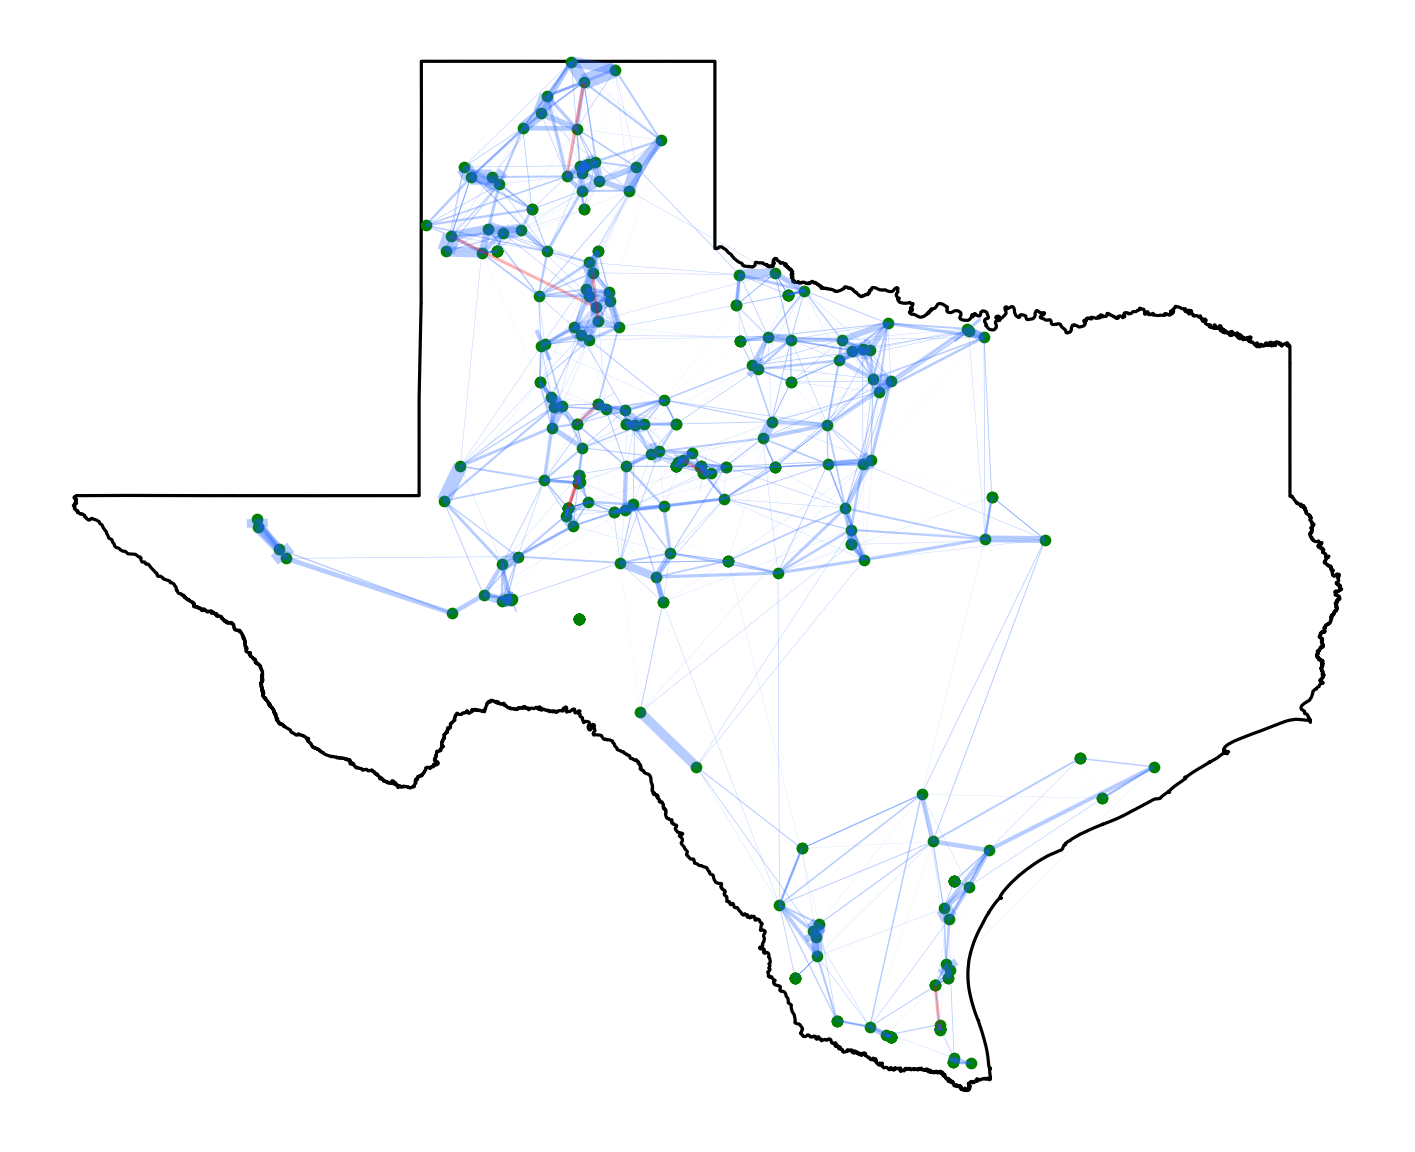

In [5]:
import numpy as np
from itertools import combinations as combn
from shapely.geometry import LineString


asset_cov = ge.model.asset_cov
prec_mat = np.linalg.inv(asset_cov)
pcor_mat = -prec_mat / np.sqrt(np.outer(np.diag(prec_mat), np.diag(prec_mat)))

cnct_dict = {
    (asset1, asset2): {
        'geometry': LineString([gdf.geometry[asset1], gdf.geometry[asset2]]),
        'pcor_val': pcor_mat[i, j]
        }
    for (i, asset1), (j, asset2) in combn(enumerate(asset_cov.index), 2)
    if np.abs(pcor_mat[i, j]) >= 0.02
    }

edges_gdf = gpd.GeoDataFrame(cnct_dict).transpose()
edges_gdf = edges_gdf.set_geometry('geometry')
ax = tx.plot(facecolor="none", edgecolor='black', figsize=(18, 18), linewidth=2.3)
gdf.plot(ax=ax, marker='o', linewidth=0, markersize=71, c='green')

sign_vec = ['#1A5FFF' if val > 0 else "#FF0000" for val in edges_gdf.pcor_val]
edges_gdf.plot(ax=ax, color=sign_vec,
               linewidth=(edges_gdf.pcor_val - 0.02) * 53, alpha=0.31)

_ = ax.axis('off')

Having fit the model, we can now produce scenarios. In the case of wind, creating scenarios may also take a few minutes.

In [6]:
ge.create_scenario(scenario_count, wind_site_forecast_futures)

In [7]:
from ipywidgets import interact, Dropdown
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def plot_wind_scenarios(wind_site):
    ax = tx.plot(facecolor="none", edgecolor='black', figsize=(18, 18), linewidth=2.3)

    gdf.plot(ax=ax, marker='o', linewidth=0, markersize=71, c='green')
    edges_gdf.plot(ax=ax, color=sign_vec,
                   linewidth=(edges_gdf.pcor_val - 0.05) * 53, alpha=0.31)

    cntr_x, cntr_y = ge.meta_df.longitude.mean(), ge.meta_df.latitude.mean()
    site_x, site_y = ge.meta_df.loc[wind_site, ['longitude', 'latitude']]
    xdiff, ydiff = site_x - cntr_x, site_y - cntr_y

    cntr_dist = (xdiff ** 2 + ydiff ** 2) ** 0.5
    site_cos, site_sin = xdiff / cntr_dist, ydiff / cntr_dist
    scen_x, scen_y = cntr_x + 8.5 * site_cos, cntr_y + 8.5 * site_sin

    scen_size = 7.5, 4
    scen_bbox = (scen_x - scen_size[0] / 2, scen_y - scen_size[1] / 2,
                 scen_size[0], scen_size[1])

    scen_ax = inset_axes(ax, width='100%', height='100%',
                         bbox_to_anchor=scen_bbox, bbox_transform=ax.transData,
                         loc=10, borderpad=0)
    
    ax.plot([site_x + 0 * site_cos, scen_x - 3.8 * site_cos],
            [site_y + 0 * site_sin, scen_y - 2 * site_sin],
            linewidth=4.3, c='black', alpha=0.53, linestyle='dotted')
    
    for i in range(scenario_count):
        scen_ax.plot(ge.scenarios['wind'].iloc[i][wind_site],
                     c='black', alpha=0.13, lw=0.2)

    plt_fcst = ge.forecasts['wind'][wind_site]
    scen_ax.plot(plt_fcst, c=fcst_clr, alpha=0.47, lw=4.1)
    scen_ax.plot(wind_site_actual_futures.loc[plt_fcst.index, wind_site],
                 c=actual_clr, alpha=0.47, lw=4.1)

    scen_ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    scen_ax.tick_params(axis='both', labelsize=17)
    scen_ax.grid(linewidth=0.9, alpha=0.41)
    scen_ax.set_ylim((0, scen_ax.get_ylim()[1]))

    quant_df = ge.scenarios['wind'][wind_site].quantile([0.25, 0.75])
    scen_ax.fill_between(quant_df.columns, quant_df.iloc[0], quant_df.iloc[1],
                         color='red', alpha=0.31)

    lgnd_ptchs = [Patch(color='black', alpha=0.23, label="Scenarios"),
                  Patch(color='red', alpha=0.41, label="Interquartile Range"),
                  Patch(color=fcst_clr, alpha=0.81, label="Forecast"),
                  Patch(color=actual_clr, alpha=0.81, label="Actual")]

    _ = scen_ax.legend(handles=lgnd_ptchs, frameon=False,
                       bbox_to_anchor=(0.5, 1), loc=8,
                       fontsize=13, ncol=4, handletextpad=0.5)

    ax.axis('off')

    
w = Dropdown(options=ge.asset_list, description="Scenarios for generator:",
             layout={'align_self': 'center'}, style={'description_width': 'initial'},
             disabled=False)
_ = interact(plot_wind_scenarios, wind_site=w)

interactive(children=(Dropdown(description='Scenarios for generator:', layout=Layout(align_self='center'), opt…